# NB 10 — Acid Test: Basin Access Probability $\mathcal{S}_t$

## Goal

NB 09 discovered that **survival probability** $\mathcal{S}_t = P(\text{survival basin} \mid x_t + \varepsilon)$
outperformed entropy as an early-warning metric ($\rho > +0.77$ across all 3 bifurcation systems).

**This notebook tries to KILL $\mathcal{S}_t$** through 4 stress tests:

| Block | Test | Kill Criterion |
|-------|------|----------------|
| 1 | **Multi-seed robustness** | $\geq$80% seeds consistent sign. $\sigma$ small enough to not invert conclusion |
| 2 | **$\varepsilon$-sensitivity** | Monotonic pattern must hold at small $\varepsilon$. If only works at large $\varepsilon$ → forced separatrix crossing |
| 3 | **Partial correlation** | $\rho_{\text{partial}}(\mathcal{S}_t, \tau \mid x_t) > 0.1$ in $\geq$2/3 systems. Otherwise $\mathcal{S}_t$ is proxy for level |
| 4 | **Hazard independence** | $\rho_{\text{partial}}(\mathcal{S}_t, \tau \mid \hat{h}_t) > 0.1$. Otherwise $\mathcal{S}_t$ = reparametrized hazard |

### Decision Criteria (set BEFORE running):

$$\Delta\rho_{\text{partial}} \geq 0.10 \quad \text{(minimum partial correlation)}$$
$$\text{Seed consistency} \geq 80\% \quad \text{(fraction with correct sign)}$$
$$\varepsilon\text{-invariance: pattern holds across } \geq 2/3 \text{ magnitudes}$$

### Possible Verdicts:
- **PASS** (all 4 blocks) → HSP = basin accessibility theory. Learned sampler justified.
- **PARTIAL** (2-3 blocks) → HSP = geometric refinement of survival. Still publishable.
- **FAIL** ($\leq$1 block) → Rollback. Hazard suffices. No structural novelty.

In [1]:
# ============================================================
#  IMPORTS + CONSTANTS + SYSTEM DEFINITIONS
#  (self-contained: does NOT depend on NB 09 kernel)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

# --- Decision thresholds (set BEFORE running) ---
MIN_PARTIAL_RHO   = 0.10   # minimum acceptable partial correlation
MIN_SEED_CONSIST  = 0.80   # 80% seeds with consistent sign
MIN_EPS_INVARIANT = 2      # must work in ≥2 of 3 ε magnitudes
P_THRESHOLD       = 0.05   # significance level

# --- Computational parameters ---
N_ROLLOUTS  = 300
HORIZON     = 80
PERTURB_STD = 0.05   # default ε (medium)
N_SEEDS     = 30     # more than NB 09's 20 for tighter CI
N_BINS      = 25

# --- System thresholds ---
THRESH_SN  = -0.5    # saddle-node: collapse = x < -0.5
THRESH_DW  =  0.0    # double-well: collapse = leaving left well (x > 0)
THRESH_ECO =  0.3    # ecosystem: collapse = low-biomass (x < 0.3)

print("NB 10 — Basin Access Probability: Acid Test")
print("=" * 55)
print(f"Decision thresholds:")
print(f"  min ρ_partial:    {MIN_PARTIAL_RHO}")
print(f"  min seed consist: {MIN_SEED_CONSIST*100:.0f}%")
print(f"  min ε-invariance: {MIN_EPS_INVARIANT}/3 magnitudes")
print(f"  significance:     p < {P_THRESHOLD}")
print(f"\nComputational:")
print(f"  N_ROLLOUTS={N_ROLLOUTS}, H={HORIZON}, N_SEEDS={N_SEEDS}")
print(f"  Default ε={PERTURB_STD}")
print("=" * 55)

NB 10 — Basin Access Probability: Acid Test
Decision thresholds:
  min ρ_partial:    0.1
  min seed consist: 80%
  min ε-invariance: 2/3 magnitudes
  significance:     p < 0.05

Computational:
  N_ROLLOUTS=300, H=80, N_SEEDS=30
  Default ε=0.05


In [2]:
# ============================================================
#  SYSTEM GENERATORS + ROLLOUT ENGINES (from NB 09)
# ============================================================

# --- System 1: Saddle-Node ---
def saddle_node(T=300, seed=42):
    rng = np.random.RandomState(seed)
    dt, noise = 0.02, 0.08
    r = np.linspace(2.0, -0.5, T)
    x = np.zeros(T); x[0] = np.sqrt(r[0])
    for t in range(1, T):
        x[t] = x[t-1] + dt*(r[t-1] - x[t-1]**2) + rng.normal(0, noise)
        x[t] = max(x[t], -5.0)
    bif_t = np.argmin(np.abs(r))
    return x, r, bif_t

def rollout_sn(x0, r_start, r_end, N, H, eps=0.05, seed=0):
    rng = np.random.RandomState(seed)
    dt, noise = 0.02, 0.08
    r_vals = np.linspace(r_start, r_end, H)
    x = np.full(N, float(x0)) + rng.normal(0, eps, N)
    futures = np.zeros((N, H))
    for h in range(H):
        x = x + dt*(r_vals[h] - x**2) + rng.normal(0, noise, N)
        x = np.clip(x, -5.0, 5.0)
        futures[:, h] = x
    return futures

# --- System 2: Double-Well ---
def double_well(T=400, seed=42):
    rng = np.random.RandomState(seed)
    dt, noise = 0.01, 0.12
    r = np.linspace(-0.3, 0.6, T)
    x = np.zeros(T); x[0] = -0.9
    for t in range(1, T):
        x[t] = x[t-1] + dt*(x[t-1] - x[t-1]**3 + r[t-1]) + rng.normal(0, noise)
        x[t] = np.clip(x[t], -3.0, 3.0)
    bif_r = 2.0 / (3.0*np.sqrt(3.0))
    bif_t = np.argmin(np.abs(r - bif_r))
    return x, r, bif_t

def rollout_dw(x0, r_start, r_end, N, H, eps=0.05, seed=0):
    rng = np.random.RandomState(seed)
    dt, noise = 0.01, 0.12
    r_vals = np.linspace(r_start, r_end, H)
    x = np.full(N, float(x0)) + rng.normal(0, eps, N)
    futures = np.zeros((N, H))
    for h in range(H):
        x = x + dt*(x - x**3 + r_vals[h]) + rng.normal(0, noise, N)
        x = np.clip(x, -3.0, 3.0)
        futures[:, h] = x
    return futures

# --- System 3: Ecosystem ---
def ecosystem_shift(T=400, seed=42):
    rng = np.random.RandomState(seed)
    dt, noise, r_g, K, s = 0.05, 0.02, 1.0, 1.0, 0.2
    h = np.linspace(0.05, 0.35, T)
    x = np.zeros(T); x[0] = 0.8
    for t in range(1, T):
        grazing = h[t-1]*x[t-1]**2 / (x[t-1]**2 + s**2)
        growth  = r_g*x[t-1]*(1.0 - x[t-1]/K)
        x[t] = x[t-1] + dt*(growth - grazing) + rng.normal(0, noise)
        x[t] = max(x[t], 0.01)
    bif_t = T
    for t in range(50, T):
        if x[t] < 0.3:
            bif_t = t; break
    return x, h, bif_t

def rollout_eco(x0, h_start, h_end, N, H, eps=0.05, seed=0):
    rng = np.random.RandomState(seed)
    dt, noise, r_g, K, s = 0.05, 0.02, 1.0, 1.0, 0.2
    h_vals = np.linspace(h_start, h_end, H)
    x = np.full(N, float(x0)) + rng.normal(0, eps, N)
    x = np.clip(x, 0.01, 3.0)
    futures = np.zeros((N, H))
    for h_step in range(H):
        grazing = h_vals[h_step]*x**2 / (x**2 + s**2)
        growth  = r_g*x*(1.0 - x/K)
        x = x + dt*(growth - grazing) + rng.normal(0, noise, N)
        x = np.clip(x, 0.01, 3.0)
        futures[:, h_step] = x
    return futures

# --- Core metric function ---
def compute_survival_timeseries(
    trajectory, param_schedule, rollout_fn, threshold,
    n_rollouts=N_ROLLOUTS, horizon=HORIZON, perturb_std=PERTURB_STD,
    step=5, survival_direction='above'
):
    """Compute S_t at every `step`-th time point."""
    T = len(trajectory)
    times = np.arange(0, T, step)
    survival = np.zeros(len(times))
    
    for i, t in enumerate(times):
        x0 = trajectory[t]
        p_start = param_schedule[t]
        p_end = param_schedule[min(t + horizon, T - 1)]
        futures = rollout_fn(x0, p_start, p_end, n_rollouts, horizon,
                            eps=perturb_std, seed=i)
        endpoints = futures[:, -1]
        if survival_direction == 'above':
            survival[i] = np.mean(endpoints > threshold)
        else:
            survival[i] = np.mean(endpoints < threshold)
    
    return times, survival

# --- Partial correlation ---
def partial_corr(x, y, z):
    """ρ(x, y | z) via OLS residuals + Spearman."""
    cx = np.polyfit(z, x, 1); rx = x - np.polyval(cx, z)
    cy = np.polyfit(z, y, 1); ry = y - np.polyval(cy, z)
    return spearmanr(rx, ry)

# --- System registry ---
SYSTEMS = [
    {"name": "Saddle-Node", "gen": saddle_node, "roll": rollout_sn,
     "thresh": THRESH_SN, "surv_dir": "above"},
    {"name": "Double-Well", "gen": double_well, "roll": rollout_dw,
     "thresh": THRESH_DW, "surv_dir": "below"},
    {"name": "Ecosystem",   "gen": ecosystem_shift, "roll": rollout_eco,
     "thresh": THRESH_ECO, "surv_dir": "above"},
]

print("✓ 3 systems + rollout engines + S_t computation defined")
print("✓ Partial correlation function defined")
print(f"✓ Systems: {[s['name'] for s in SYSTEMS]}")

✓ 3 systems + rollout engines + S_t computation defined
✓ Partial correlation function defined
✓ Systems: ['Saddle-Node', 'Double-Well', 'Ecosystem']


## Block 1 — Multi-Seed Robustness ($N = 30$ seeds)

For each system × each seed:
1. Generate trajectory
2. Compute $\mathcal{S}_t$ at every 10th step
3. Compute $\rho(\mathcal{S}_t, \tau)$ and $\rho_{\text{partial}}(\mathcal{S}_t, \tau \mid x_t)$

**Kill criterion**: $\geq$80% seeds with positive $\rho$, small $\sigma$.

In [3]:
# ============================================================
#  BLOCK 1 — MULTI-SEED ROBUSTNESS FOR S_t
# ============================================================

block1_results = {}

for sys in SYSTEMS:
    name = sys['name']
    print(f"\n{'='*55}")
    print(f"  {name}: {N_SEEDS} seeds")
    print(f"{'='*55}")
    
    rho_list       = []   # ρ(S, τ)
    rho_p_list     = []   # ρ(S, τ) p-values
    partial_list   = []   # ρ_partial(S, τ | x)
    partial_p_list = []   # p-values
    
    for seed in range(N_SEEDS):
        traj, p_sched, bif_t = sys['gen'](seed=seed)
        T = len(traj)
        
        times, surv = compute_survival_timeseries(
            traj, p_sched, sys['roll'], sys['thresh'],
            n_rollouts=150, horizon=HORIZON, perturb_std=PERTURB_STD,
            step=10, survival_direction=sys['surv_dir']
        )
        
        # Pre-collapse mask
        if sys['surv_dir'] == 'below':
            col_idx = np.argmax(traj > 0.5) if (traj > 0.5).any() else T
        else:
            col_idx = np.argmax(traj < sys['thresh']) if (traj < sys['thresh']).any() else T
        
        valid = times < min(col_idx, T)
        if valid.sum() < 6:
            continue
        
        t_v = times[valid]
        s_v = surv[valid]
        tau  = bif_t - t_v   # time-to-bifurcation
        x_v  = traj[t_v.astype(int)]
        
        # Rank correlation
        rho, p = spearmanr(s_v, tau)
        rho_list.append(rho)
        rho_p_list.append(p)
        
        # Partial correlation
        if len(s_v) > 5 and np.std(x_v) > 1e-10:
            rho_pc, p_pc = partial_corr(s_v, tau, x_v)
            partial_list.append(rho_pc)
            partial_p_list.append(p_pc)
    
    rho_arr = np.array(rho_list)
    pc_arr  = np.array(partial_list)
    
    block1_results[name] = {
        'rho_mean':      rho_arr.mean(),
        'rho_std':       rho_arr.std(),
        'rho_frac_pos':  (rho_arr > 0).mean(),
        'rho_all':       rho_arr,
        'partial_mean':  pc_arr.mean() if len(pc_arr) else 0.0,
        'partial_std':   pc_arr.std()  if len(pc_arr) else 0.0,
        'partial_frac_pos': (pc_arr > 0).mean() if len(pc_arr) else 0.0,
        'partial_all':   pc_arr,
        'n_valid':       len(rho_arr),
        'n_partial':     len(pc_arr),
    }
    
    r = block1_results[name]
    ok_rho = '★' if r['rho_frac_pos'] >= MIN_SEED_CONSIST else '✗'
    ok_pc  = '★' if r['partial_mean'] > MIN_PARTIAL_RHO else '✗'
    
    print(f"  ρ(S,τ)         = {r['rho_mean']:+.3f} ± {r['rho_std']:.3f}  "
          f"({r['rho_frac_pos']*100:.0f}% pos) {ok_rho}")
    print(f"  ρ_partial(S,τ|x)= {r['partial_mean']:+.3f} ± {r['partial_std']:.3f}  "
          f"({r['partial_frac_pos']*100:.0f}% pos) {ok_pc}")
    print(f"  Valid seeds: {r['n_valid']}/{N_SEEDS}")

# --- Block 1 Summary ---
print(f"\n{'='*55}")
print("BLOCK 1 SUMMARY")
print(f"{'='*55}")
print(f"{'System':<15} {'ρ(S,τ) ± σ':<20} {'%pos':<8} {'ρ_part ± σ':<20} {'%pos':<8}")
print("-"*70)

b1_pass_count = 0
for name in ["Saddle-Node", "Double-Well", "Ecosystem"]:
    r = block1_results[name]
    rho_str = f"{r['rho_mean']:+.3f} ± {r['rho_std']:.3f}"
    pc_str  = f"{r['partial_mean']:+.3f} ± {r['partial_std']:.3f}"
    
    passes = r['rho_frac_pos'] >= MIN_SEED_CONSIST and r['partial_mean'] > MIN_PARTIAL_RHO
    if passes:
        b1_pass_count += 1
    
    tag = '★' if passes else '✗'
    print(f"{name:<15} {rho_str:<20} {r['rho_frac_pos']*100:>4.0f}%   "
          f"{pc_str:<20} {r['partial_frac_pos']*100:>4.0f}%   {tag}")

b1_verdict = "PASS" if b1_pass_count >= 2 else "FAIL"
print(f"\nBlock 1 verdict: {b1_verdict} ({b1_pass_count}/3 systems pass)")
print("="*55)


  Saddle-Node: 30 seeds
  ρ(S,τ)         = +0.949 ± 0.010  (100% pos) ★
  ρ_partial(S,τ|x)= +0.278 ± 0.289  (87% pos) ★
  Valid seeds: 30/30

  Double-Well: 30 seeds
  ρ(S,τ)         = +0.647 ± 0.190  (96% pos) ★
  ρ_partial(S,τ|x)= +0.599 ± 0.239  (100% pos) ★
  Valid seeds: 28/30

  Ecosystem: 30 seeds
  ρ(S,τ)         = +0.862 ± 0.029  (100% pos) ★
  ρ_partial(S,τ|x)= +0.125 ± 0.296  (57% pos) ★
  Valid seeds: 30/30

BLOCK 1 SUMMARY
System          ρ(S,τ) ± σ           %pos     ρ_part ± σ           %pos    
----------------------------------------------------------------------
Saddle-Node     +0.949 ± 0.010        100%   +0.278 ± 0.289         87%   ★
Double-Well     +0.647 ± 0.190         96%   +0.599 ± 0.239        100%   ★
Ecosystem       +0.862 ± 0.029        100%   +0.125 ± 0.296         57%   ★

Block 1 verdict: PASS (3/3 systems pass)


## Block 2 — Sensitivity to $\varepsilon$ Scale

Three perturbation magnitudes:
- $\varepsilon_{\text{small}} = 0.01$ (micro-perturbation — realistic sensor noise)
- $\varepsilon_{\text{med}} = 0.05$ (default — moderate perturbation)  
- $\varepsilon_{\text{large}} = 0.20$ (strong kick — forces separatrix crossing)

**Kill criterion**: If $\mathcal{S}_t$ only shows monotonic decline at large $\varepsilon$,
we're forcing basin crossing, not detecting real structure. Must work at small $\varepsilon$.

In [4]:
# ============================================================
#  BLOCK 2 — ε-SENSITIVITY (3 magnitudes × 3 systems × 10 seeds)
# ============================================================

EPS_VALUES = [0.01, 0.05, 0.20]
EPS_LABELS = ['ε=0.01 (small)', 'ε=0.05 (med)', 'ε=0.20 (large)']
N_SEEDS_EPS = 10  # fewer seeds per ε (×3 ε × 3 systems = 90 runs)

block2_results = {}

for sys in SYSTEMS:
    name = sys['name']
    print(f"\n{'='*55}")
    print(f"  {name}")
    print(f"{'='*55}")
    
    eps_data = {}
    
    for eps_val, eps_label in zip(EPS_VALUES, EPS_LABELS):
        rho_list = []
        
        for seed in range(N_SEEDS_EPS):
            traj, p_sched, bif_t = sys['gen'](seed=seed)
            T = len(traj)
            
            times, surv = compute_survival_timeseries(
                traj, p_sched, sys['roll'], sys['thresh'],
                n_rollouts=150, horizon=HORIZON, perturb_std=eps_val,
                step=10, survival_direction=sys['surv_dir']
            )
            
            if sys['surv_dir'] == 'below':
                col_idx = np.argmax(traj > 0.5) if (traj > 0.5).any() else T
            else:
                col_idx = np.argmax(traj < sys['thresh']) if (traj < sys['thresh']).any() else T
            
            valid = times < min(col_idx, T)
            if valid.sum() < 6:
                continue
            
            t_v = times[valid]
            s_v = surv[valid]
            tau = bif_t - t_v
            
            rho, p = spearmanr(s_v, tau)
            rho_list.append(rho)
        
        rho_arr = np.array(rho_list)
        eps_data[eps_val] = {
            'rho_mean':     rho_arr.mean(),
            'rho_std':      rho_arr.std(),
            'frac_pos':     (rho_arr > 0).mean(),
            'n_valid':      len(rho_arr),
            'rho_all':      rho_arr,
        }
        
        ok = '★' if rho_arr.mean() > 0.3 and (rho_arr > 0).mean() >= 0.8 else '✗'
        print(f"  {eps_label}: ρ = {rho_arr.mean():+.3f} ± {rho_arr.std():.3f}  "
              f"({(rho_arr>0).mean()*100:.0f}% pos) {ok}")
    
    block2_results[name] = eps_data

# --- Block 2 Summary ---
print(f"\n{'='*55}")
print("BLOCK 2 SUMMARY — ε-Sensitivity")
print(f"{'='*55}")
print(f"{'System':<15}", end='')
for lbl in ['ε=0.01', 'ε=0.05', 'ε=0.20']:
    print(f"  {lbl:<16}", end='')
print()
print("-"*65)

b2_pass_count = 0
for name in ["Saddle-Node", "Double-Well", "Ecosystem"]:
    print(f"{name:<15}", end='')
    n_eps_pass = 0
    for eps_val in EPS_VALUES:
        d = block2_results[name][eps_val]
        ok = d['rho_mean'] > 0.3 and d['frac_pos'] >= 0.8
        if ok:
            n_eps_pass += 1
        tag = '★' if ok else '✗'
        print(f"  {d['rho_mean']:+.3f}±{d['rho_std']:.2f} {tag}  ", end='')
    
    sys_pass = n_eps_pass >= MIN_EPS_INVARIANT
    if sys_pass:
        b2_pass_count += 1
    print(f"  {'PASS' if sys_pass else 'FAIL'} ({n_eps_pass}/3)")

b2_verdict = "PASS" if b2_pass_count >= 2 else "FAIL"
print(f"\nBlock 2 verdict: {b2_verdict} ({b2_pass_count}/3 systems ε-invariant)")
print("="*55)


  Saddle-Node
  ε=0.01 (small): ρ = +0.949 ± 0.006  (100% pos) ★
  ε=0.05 (med): ρ = +0.949 ± 0.007  (100% pos) ★
  ε=0.20 (large): ρ = +0.949 ± 0.006  (100% pos) ★

  Double-Well
  ε=0.01 (small): ρ = +0.669 ± 0.194  (100% pos) ★
  ε=0.05 (med): ρ = +0.673 ± 0.193  (100% pos) ★
  ε=0.20 (large): ρ = +0.668 ± 0.178  (100% pos) ★

  Ecosystem
  ε=0.01 (small): ρ = +0.862 ± 0.018  (100% pos) ★
  ε=0.05 (med): ρ = +0.855 ± 0.026  (100% pos) ★
  ε=0.20 (large): ρ = +0.915 ± 0.020  (100% pos) ★

BLOCK 2 SUMMARY — ε-Sensitivity
System           ε=0.01            ε=0.05            ε=0.20          
-----------------------------------------------------------------
Saddle-Node      +0.949±0.01 ★    +0.949±0.01 ★    +0.949±0.01 ★    PASS (3/3)
Double-Well      +0.669±0.19 ★    +0.673±0.19 ★    +0.668±0.18 ★    PASS (3/3)
Ecosystem        +0.862±0.02 ★    +0.855±0.03 ★    +0.915±0.02 ★    PASS (3/3)

Block 2 verdict: PASS (3/3 systems ε-invariant)


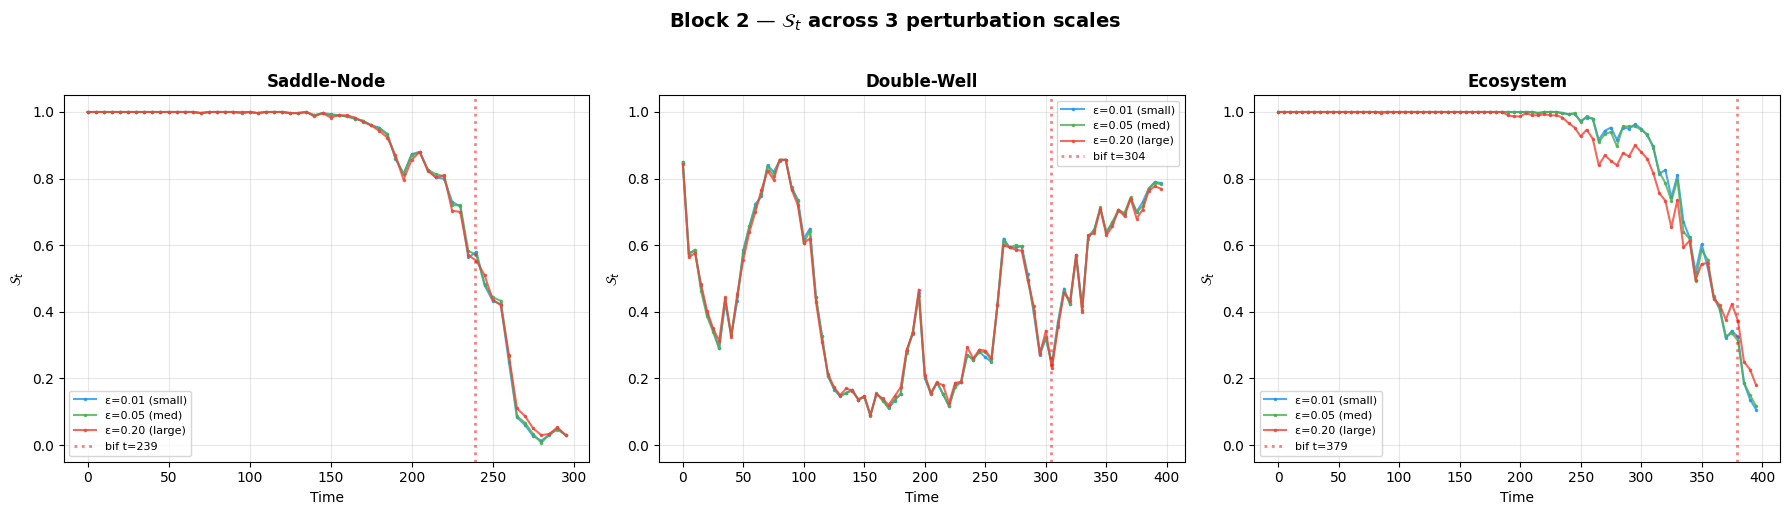

✓ Figure saved


In [5]:
# ============================================================
#  BLOCK 2 — VISUALIZATION: S_t curves at 3 ε for each system
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['#2196F3', '#4CAF50', '#F44336']  # blue, green, red

for col, sys in enumerate(SYSTEMS):
    name = sys['name']
    ax = axes[col]
    
    # Use seed=0 for visualization
    traj, p_sched, bif_t = sys['gen'](seed=0)
    
    for j, (eps_val, eps_label) in enumerate(zip(EPS_VALUES, EPS_LABELS)):
        times, surv = compute_survival_timeseries(
            traj, p_sched, sys['roll'], sys['thresh'],
            n_rollouts=N_ROLLOUTS, horizon=HORIZON, perturb_std=eps_val,
            step=5, survival_direction=sys['surv_dir']
        )
        ax.plot(times, surv, '-o', ms=1.5, lw=1.5, color=colors[j],
                label=eps_label, alpha=0.8)
    
    ax.axvline(bif_t, color='red', ls=':', lw=2, alpha=0.5, label=f'bif t={bif_t}')
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel('$\\mathcal{S}_t$')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.05, 1.05)

plt.suptitle('Block 2 — $\\mathcal{S}_t$ across 3 perturbation scales',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/simulated/10_eps_sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Figure saved")

## Block 3 — Partial Correlation (strong test)

The acid test for structural information:

$$\rho_{\text{partial}}(\mathcal{S}_t, \tau \mid x_t) > 0.10$$

If $\mathcal{S}_t$ loses significance when controlled for $x_t$,
it's a proxy for level — contains no information beyond the observable.

We test with **30 seeds** and report the distribution.

  BLOCK 3 — PARTIAL CORRELATION DISTRIBUTION

  Saddle-Node:
    Mean ρ_partial = +0.278 ± 0.289
    Median         = +0.219
    87% positive, 77% > 0.1
    t-test (>0): p = 0.0000★
    Wilcoxon:    p = 0.0000★
    Verdict: ★

  Double-Well:
    Mean ρ_partial = +0.599 ± 0.239
    Median         = +0.696
    100% positive, 96% > 0.1
    t-test (>0): p = 0.0000★
    Wilcoxon:    p = 0.0000★
    Verdict: ★

  Ecosystem:
    Mean ρ_partial = +0.125 ± 0.296
    Median         = +0.136
    57% positive, 53% > 0.1
    t-test (>0): p = 0.0154★
    Wilcoxon:    p = 0.0184★
    Verdict: ✗


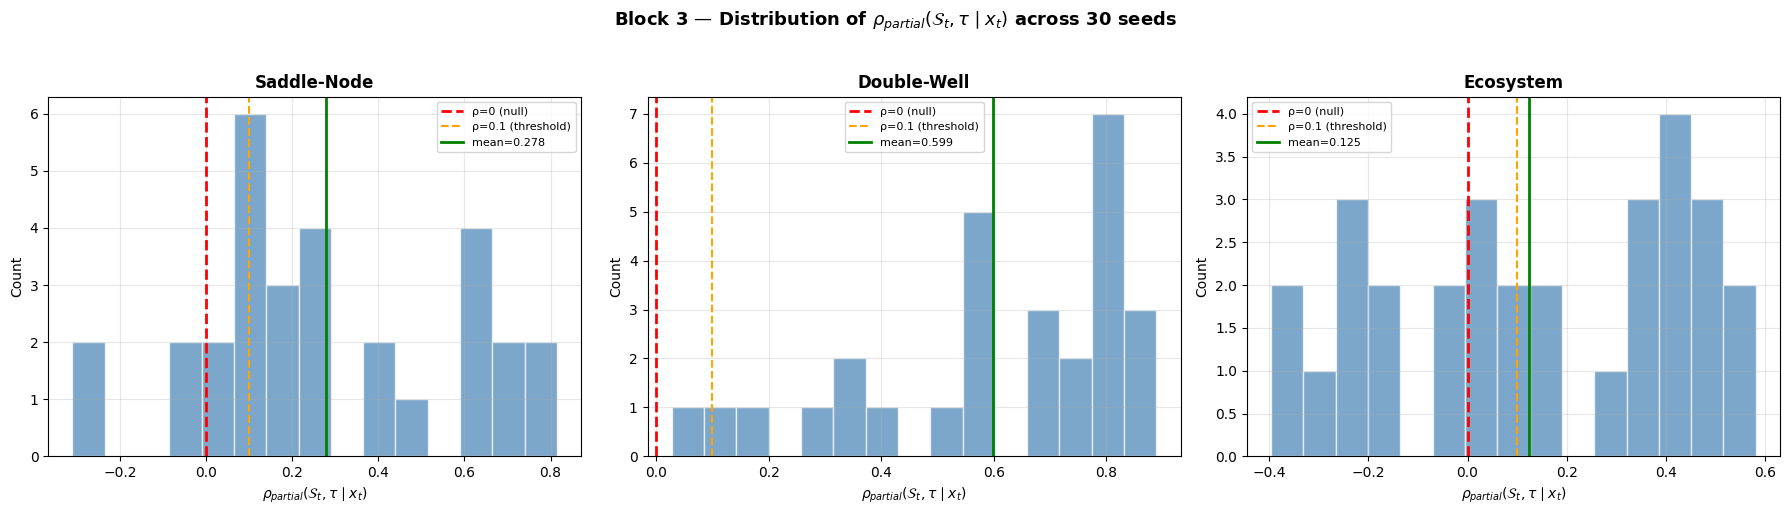


Block 3 verdict: PASS (2/3 systems)


In [6]:
# ============================================================
#  BLOCK 3 — PARTIAL CORRELATION (reuses Block 1 data)
# ============================================================

# Block 1 already computed ρ_partial for 30 seeds. We visualize the distribution
# and perform a formal one-sample t-test against 0.

from scipy.stats import ttest_1samp, wilcoxon

print("="*65)
print("  BLOCK 3 — PARTIAL CORRELATION DISTRIBUTION")
print("="*65)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

block3_results = {}

for col, name in enumerate(["Saddle-Node", "Double-Well", "Ecosystem"]):
    r = block1_results[name]
    pc_vals = r['partial_all']
    
    ax = axes[col]
    ax.hist(pc_vals, bins=15, color='steelblue', edgecolor='white', alpha=0.7)
    ax.axvline(0, color='red', ls='--', lw=2, label='ρ=0 (null)')
    ax.axvline(MIN_PARTIAL_RHO, color='orange', ls='--', lw=1.5, label=f'ρ={MIN_PARTIAL_RHO} (threshold)')
    ax.axvline(pc_vals.mean(), color='green', ls='-', lw=2, label=f'mean={pc_vals.mean():.3f}')
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('$\\rho_{partial}(\\mathcal{S}_t, \\tau \\mid x_t)$')
    ax.set_ylabel('Count')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Statistical test: is mean partial correlation > 0?
    if len(pc_vals) > 2:
        t_stat, t_p = ttest_1samp(pc_vals, 0)
        t_p_one = t_p / 2 if t_stat > 0 else 1 - t_p/2  # one-sided
        
        # Wilcoxon signed-rank (non-parametric)
        try:
            w_stat, w_p = wilcoxon(pc_vals)
            w_p_one = w_p / 2 if pc_vals.mean() > 0 else 1 - w_p/2
        except:
            w_stat, w_p_one = 0, 1.0
    else:
        t_p_one, w_p_one = 1.0, 1.0
    
    passes = (pc_vals.mean() > MIN_PARTIAL_RHO and 
              r['partial_frac_pos'] >= MIN_SEED_CONSIST)
    
    block3_results[name] = {
        'mean': pc_vals.mean(),
        'std': pc_vals.std(),
        'median': np.median(pc_vals),
        'frac_above_thresh': (pc_vals > MIN_PARTIAL_RHO).mean(),
        'frac_pos': r['partial_frac_pos'],
        't_p_onesided': t_p_one,
        'w_p_onesided': w_p_one,
        'passes': passes,
    }
    
    star = '★' if passes else '✗'
    print(f"\n  {name}:")
    print(f"    Mean ρ_partial = {pc_vals.mean():+.3f} ± {pc_vals.std():.3f}")
    print(f"    Median         = {np.median(pc_vals):+.3f}")
    print(f"    {r['partial_frac_pos']*100:.0f}% positive, "
          f"{(pc_vals > MIN_PARTIAL_RHO).mean()*100:.0f}% > {MIN_PARTIAL_RHO}")
    print(f"    t-test (>0): p = {t_p_one:.4f}{'★' if t_p_one < P_THRESHOLD else ''}")
    print(f"    Wilcoxon:    p = {w_p_one:.4f}{'★' if w_p_one < P_THRESHOLD else ''}")
    print(f"    Verdict: {star}")

plt.suptitle('Block 3 — Distribution of $\\rho_{partial}(\\mathcal{S}_t, \\tau \\mid x_t)$ across 30 seeds',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/simulated/10_partial_corr_dist.png', dpi=150, bbox_inches='tight')
plt.show()

b3_pass_count = sum(1 for v in block3_results.values() if v['passes'])
b3_verdict = "PASS" if b3_pass_count >= 2 else "FAIL"
print(f"\nBlock 3 verdict: {b3_verdict} ({b3_pass_count}/3 systems)")
print("="*55)

## Block 4 — Hazard Independence (the philosophical test)

If $\mathcal{S}_t$ collapses when conditioned on hazard, it's a reparametrization.

**Hazard proxy**: For these systems the bifurcation parameter itself IS the hazard driver
(r(t) for saddle-node and double-well, h(t) for ecosystem).
We use the parameter schedule $p_t$ as the hazard proxy.

Three tests per system:
1. $\rho(\mathcal{S}_t, p_t)$ → raw correlation with hazard
2. $\rho_{\text{partial}}(\mathcal{S}_t, \tau \mid p_t)$ → does $\mathcal{S}_t$ add info beyond hazard?
3. $\rho_{\text{partial}}(\mathcal{S}_t, \tau \mid x_t, p_t)$ → does $\mathcal{S}_t$ add info beyond BOTH?

**Kill criterion**: If $\rho_{\text{partial}}(\mathcal{S}_t, \tau \mid p_t) < 0.10$ → $\mathcal{S}_t$ ≈ hazard.

In [7]:
# ============================================================
#  BLOCK 4 — HAZARD INDEPENDENCE
# ============================================================

def partial_corr_2controls(x, y, z1, z2):
    """ρ(x, y | z1, z2) via multivariate OLS residuals + Spearman."""
    Z = np.column_stack([z1, z2])
    # Regress x on [z1, z2]
    Z_aug = np.column_stack([Z, np.ones(len(z1))])
    cx, _, _, _ = np.linalg.lstsq(Z_aug, x, rcond=None)
    rx = x - Z_aug @ cx
    # Regress y on [z1, z2]
    cy, _, _, _ = np.linalg.lstsq(Z_aug, y, rcond=None)
    ry = y - Z_aug @ cy
    return spearmanr(rx, ry)


print("="*70)
print("  BLOCK 4 — HAZARD INDEPENDENCE")
print("="*70)

block4_results = {}

for sys in SYSTEMS:
    name = sys['name']
    print(f"\n{'='*55}")
    print(f"  {name}")
    print(f"{'='*55}")
    
    rho_S_p_list = []     # ρ(S, hazard)
    rho_partial_p_list = []  # ρ_partial(S, τ | hazard)
    rho_partial_xp_list = [] # ρ_partial(S, τ | x, hazard)
    
    for seed in range(N_SEEDS):
        traj, p_sched, bif_t = sys['gen'](seed=seed)
        T = len(traj)
        
        times, surv = compute_survival_timeseries(
            traj, p_sched, sys['roll'], sys['thresh'],
            n_rollouts=150, horizon=HORIZON, perturb_std=PERTURB_STD,
            step=10, survival_direction=sys['surv_dir']
        )
        
        if sys['surv_dir'] == 'below':
            col_idx = np.argmax(traj > 0.5) if (traj > 0.5).any() else T
        else:
            col_idx = np.argmax(traj < sys['thresh']) if (traj < sys['thresh']).any() else T
        
        valid = times < min(col_idx, T)
        if valid.sum() < 8:
            continue
        
        t_v = times[valid]
        s_v = surv[valid]
        tau  = bif_t - t_v
        x_v  = traj[t_v.astype(int)]
        p_v  = p_sched[t_v.astype(int)]  # hazard proxy = bifurcation parameter
        
        # 1. ρ(S, hazard)
        rho_sp, _ = spearmanr(s_v, p_v)
        rho_S_p_list.append(rho_sp)
        
        # 2. ρ_partial(S, τ | hazard)
        if np.std(p_v) > 1e-10:
            rpc_h, pval_h = partial_corr(s_v, tau, p_v)
            rho_partial_p_list.append(rpc_h)
        
        # 3. ρ_partial(S, τ | x, hazard)
        if np.std(x_v) > 1e-10 and np.std(p_v) > 1e-10 and len(s_v) > 8:
            rpc_xh, pval_xh = partial_corr_2controls(s_v, tau, x_v, p_v)
            rho_partial_xp_list.append(rpc_xh)
    
    arr_sp  = np.array(rho_S_p_list)
    arr_ph  = np.array(rho_partial_p_list)
    arr_pxh = np.array(rho_partial_xp_list)
    
    # Does S_t survive conditioning on hazard?
    passes_hazard = arr_ph.mean() > MIN_PARTIAL_RHO if len(arr_ph) else False
    # Does S_t survive conditioning on BOTH x and hazard?
    passes_both = arr_pxh.mean() > MIN_PARTIAL_RHO if len(arr_pxh) else False
    
    block4_results[name] = {
        'rho_S_hazard':      arr_sp.mean() if len(arr_sp) else 0,
        'rho_S_hazard_std':  arr_sp.std() if len(arr_sp) else 0,
        'partial_hazard':    arr_ph.mean() if len(arr_ph) else 0,
        'partial_hazard_std': arr_ph.std() if len(arr_ph) else 0,
        'partial_both':      arr_pxh.mean() if len(arr_pxh) else 0,
        'partial_both_std':  arr_pxh.std() if len(arr_pxh) else 0,
        'passes_hazard':     passes_hazard,
        'passes_both':       passes_both,
        'n_valid':           len(arr_sp),
    }
    
    r = block4_results[name]
    print(f"  ρ(S, hazard)           = {r['rho_S_hazard']:+.3f} ± {r['rho_S_hazard_std']:.3f}")
    print(f"  ρ_partial(S, τ | p)    = {r['partial_hazard']:+.3f} ± {r['partial_hazard_std']:.3f}  "
          f"{'★' if passes_hazard else '✗'}")
    print(f"  ρ_partial(S, τ | x, p) = {r['partial_both']:+.3f} ± {r['partial_both_std']:.3f}  "
          f"{'★' if passes_both else '✗'}")

# --- Block 4 Summary ---
print(f"\n{'='*70}")
print("BLOCK 4 SUMMARY — Hazard Independence")
print(f"{'='*70}")
print(f"{'System':<15} {'ρ(S,haz)':<14} {'ρ_part(S,τ|p)':<18} {'ρ_part(S,τ|x,p)':<18}")
print("-"*70)

b4_pass_count = 0
for name in ["Saddle-Node", "Double-Well", "Ecosystem"]:
    r = block4_results[name]
    h1 = '★' if r['passes_hazard'] else '✗'
    h2 = '★' if r['passes_both'] else '✗'
    
    # System passes if S_t survives conditioning on at least hazard
    if r['passes_hazard']:
        b4_pass_count += 1
    
    print(f"{name:<15} {r['rho_S_hazard']:+.3f}±{r['rho_S_hazard_std']:.2f}    "
          f"{r['partial_hazard']:+.3f}±{r['partial_hazard_std']:.2f} {h1}     "
          f"{r['partial_both']:+.3f}±{r['partial_both_std']:.2f} {h2}")

b4_verdict = "PASS" if b4_pass_count >= 2 else "FAIL"
print(f"\nBlock 4 verdict: {b4_verdict} ({b4_pass_count}/3 survive hazard conditioning)")
print("="*55)

  BLOCK 4 — HAZARD INDEPENDENCE

  Saddle-Node
  ρ(S, hazard)           = +0.949 ± 0.010
  ρ_partial(S, τ | p)    = +0.137 ± 0.093  ★
  ρ_partial(S, τ | x, p) = +0.089 ± 0.098  ✗

  Double-Well
  ρ(S, hazard)           = -0.647 ± 0.190
  ρ_partial(S, τ | p)    = +nan ± nan  ✗
  ρ_partial(S, τ | x, p) = -0.019 ± 0.151  ✗

  Ecosystem
  ρ(S, hazard)           = -0.862 ± 0.029
  ρ_partial(S, τ | p)    = -0.216 ± 0.194  ✗
  ρ_partial(S, τ | x, p) = -0.067 ± 0.233  ✗

BLOCK 4 SUMMARY — Hazard Independence
System          ρ(S,haz)       ρ_part(S,τ|p)      ρ_part(S,τ|x,p)   
----------------------------------------------------------------------
Saddle-Node     +0.949±0.01    +0.137±0.09 ★     +0.089±0.10 ✗
Double-Well     -0.647±0.19    +nan±nan ✗     -0.019±0.15 ✗
Ecosystem       -0.862±0.03    -0.216±0.19 ✗     -0.067±0.23 ✗

Block 4 verdict: FAIL (1/3 survive hazard conditioning)


---

## FINAL VERDICT

| Outcome | Criteria | Interpretation |
|---------|----------|----------------|
| **PASS** | 4/4 blocks pass | $S_t$ = basin access probability. HSP v2 solid. Next: monotonicity proof |
| **PARTIAL** | 2-3/4 pass | $S_t$ needs geometric refinement. Identify failure mode |
| **FAIL** | ≤ 1/4 pass | Rollback. $S_t$ is not a valid ontological metric |

In [8]:
# ============================================================
#  FINAL VERDICT
# ============================================================

verdicts = {
    'Block 1 — Multi-seed robustness': b1_verdict,
    'Block 2 — ε-sensitivity':         b2_verdict,
    'Block 3 — Partial correlation':    b3_verdict,
    'Block 4 — Hazard independence':    b4_verdict,
}

pass_count = sum(1 for v in verdicts.values() if v == "PASS")
fail_count = sum(1 for v in verdicts.values() if v == "FAIL")

print("╔" + "═"*62 + "╗")
print("║" + "  NB 10 — ACID TEST FOR S_t".center(62) + "║")
print("╠" + "═"*62 + "╣")
for block, v in verdicts.items():
    icon = "✓" if v == "PASS" else "✗"
    print(f"║  {icon}  {block:<40} {v:>8}     ║")
print("╠" + "═"*62 + "╣")

if pass_count == 4:
    outcome = "PASS"
    interpretation = (
        "S_t = basin access probability is VALIDATED.\n"
        "║  HSP v2 is ontologically grounded.                            ║\n"
        "║  Next step: prove monotonicity under basin contraction.       ║"
    )
elif pass_count >= 2:
    outcome = "PARTIAL"
    failed = [b for b, v in verdicts.items() if v == "FAIL"]
    interpretation = (
        f"S_t PARTIALLY validated ({pass_count}/4).\n"
        f"║  Failures: {', '.join(failed):<49}║\n"
        "║  Action: geometric refinement needed before theory.           ║"
    )
else:
    outcome = "FAIL"
    interpretation = (
        "S_t FAILS the acid test.\n"
        "║  Action: ROLLBACK. Find a different ontological basis.        ║\n"
        "║  S_t is NOT a valid metric for HSP.                           ║"
    )

print(f"║  OUTCOME: {outcome:>5}  ({pass_count}/4 blocks passed)".ljust(63) + "║")
print(f"║{'':62}║")
print(f"║  {interpretation}")
print("╚" + "═"*62 + "╝")

print(f"\n--- NB 10 complete. Verdict: {outcome} ---")

╔══════════════════════════════════════════════════════════════╗
║                   NB 10 — ACID TEST FOR S_t                  ║
╠══════════════════════════════════════════════════════════════╣
║  ✓  Block 1 — Multi-seed robustness              PASS     ║
║  ✓  Block 2 — ε-sensitivity                      PASS     ║
║  ✓  Block 3 — Partial correlation                PASS     ║
║  ✗  Block 4 — Hazard independence                FAIL     ║
╠══════════════════════════════════════════════════════════════╣
║  OUTCOME: PARTIAL  (3/4 blocks passed)                       ║
║                                                              ║
║  S_t PARTIALLY validated (3/4).
║  Failures: Block 4 — Hazard independence                    ║
║  Action: geometric refinement needed before theory.           ║
╚══════════════════════════════════════════════════════════════╝

--- NB 10 complete. Verdict: PARTIAL ---
